# Putting All Together: Data + Model + Loss + Optimization

In [1]:
#loading cifar10 data
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
import os

"""
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 
training images and 10000 test images.
The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains 
exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random 
order, but some training batches may contain more images from one class than another. Between them, the training 
batches contain exactly 5000 images from each class.
"""


def load_batch(f_path, label_key='labels'):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    with open(f_path, 'rb') as f:
        if sys.version_info < (3,):
            d = pickle.load(f)
        else:
            d = pickle.load(f, encoding='bytes')
            # decode utf8
            d_decoded = {}
            for k, v in d.items():
                d_decoded[k.decode('utf8')] = v
            d = d_decoded
    data = d['data']
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels


def load_data(path, negatives=False):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """

    num_train_samples = 50000

    x_train_local = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train_local = np.empty((num_train_samples,), dtype='uint8')

    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        (x_train_local[(i - 1) * 10000: i * 10000, :, :, :],
         y_train_local[(i - 1) * 10000: i * 10000]) = load_batch(fpath)

    fpath = os.path.join(path, 'test_batch')
    x_test_local, y_test_local = load_batch(fpath)

    y_train_local = np.reshape(y_train_local, (len(y_train_local), 1))
    y_test_local = np.reshape(y_test_local, (len(y_test_local), 1))

    if negatives:
        x_train_local = x_train_local.transpose(0, 2, 3, 1).astype(np.float32)
        x_test_local = x_test_local.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        x_train_local = np.rollaxis(x_train_local, 1, 4)
        x_test_local = np.rollaxis(x_test_local, 1, 4)

    return (x_train_local, y_train_local), (x_test_local, y_test_local)


if __name__ == "__main__":
    """show it works"""

    cifar_10_dir = 'cifar-10-batches-py'

    (x_train, y_train), (x_test, y_test) = load_data(cifar_10_dir)

    print("Train data (x_train): ", x_train.shape)
    print("Train labels (y_train): ", y_train.shape)
    print("Test data (x_test): ", x_test.shape)
    print("Test labels (y_test): ", y_test.shape)

Train data (x_train):  (50000, 32, 32, 3)
Train labels (y_train):  (50000, 1)
Test data (x_test):  (10000, 32, 32, 3)
Test labels (y_test):  (10000, 1)


In [2]:
#Spilit data into train, val and test sets, development set(to make faster)
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# our validation data
mask = range(num_training, num_training + num_validation)
x_val = x_train[mask]
y_val = y_train[mask]

# our training data
mask = range(num_training)
x_train = x_train[mask]
y_train = y_train[mask]

# our development data
mask = np.random.choice(num_training, num_dev)
x_dev = x_train[mask]
y_dev = y_train[mask]

# our test data
mask = range(num_test)
x_test = x_test[mask]
y_test = y_test[mask]

print('train data: ',x_train.shape)
print('train labels: ',y_train.shape)
print('Validation data: ',x_val.shape)
print('Validation labels: ',y_val.shape)
print('test data: ',x_test.shape)
print('test labels: ',y_test.shape)

train data:  (49000, 32, 32, 3)
train labels:  (49000, 1)
Validation data:  (1000, 32, 32, 3)
Validation labels:  (1000, 1)
test data:  (1000, 32, 32, 3)
test labels:  (1000, 1)


In [3]:
#reshape image to 2D
x_train = np.reshape(x_train,(x_train.shape[0], -1))
x_val = np.reshape(x_val, (x_val.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))
x_dev = np.reshape(x_dev, (x_dev.shape[0],-1))
print('training shape 2d:', x_train.shape)
print('Validation data 2d:', x_val.shape)
print('test data 2d:', x_test.shape)
print('dev data 2d:', x_dev.shape)

training shape 2d: (49000, 3072)
Validation data 2d: (1000, 3072)
test data 2d: (1000, 3072)
dev data 2d: (500, 3072)


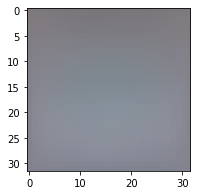

In [12]:
#subtract mean
mean_image = np.mean(x_train, axis=0)
plt.figure(figsize=(3,3))
plt.imshow(mean_image.reshape(32,32,3).astype('uint8'));

In [13]:
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
x_dev = x_dev.astype('float32')

x_train -= mean_image
x_val -= mean_image
x_test -= mean_image
x_dev -= mean_image

In [14]:
def affine_forward(x, W, b):
    """
    A linear mapping from inputs to scores.
    
    Inputs:
        - x: input matrix (N, d_1, ..., d_k)
        - W: weigh matrix (D, C)
        - b: bias vector  (C, )
    
    Outputs:
        - out: output of linear layer (N, C)
    """
    x2d = np.reshape(x, (x.shape[0], -1))  # convert 4D input matrix to 2D    
    out = np.dot(x2d, W) + b               # linear transformation
    cache = (x, W, b)                      # keep for backward step (stay with us)
    return out, cache

###################################################################

def softmax_loss(scores, y):
    """
    Softmax loss function, fully vectorized implementation.

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
        - scores: A numpy array of shape (N, C).
        - y: A numpy array of shape (N,) containing training labels;

    Outputs:
        - loss as single float
        - gradient with respect to scores
    """
    N = scores.shape[0]  # number of input data

    # compute data loss
    shifted_logits = scores - np.max(scores, axis=1, keepdims=True)
    Z = np.sum(np.exp(shifted_logits), axis=1, keepdims=True)
    log_probs = shifted_logits - np.log(Z)
    probs = np.exp(log_probs)
    loss = -np.sum(log_probs[range(N), y]) / N

    # Compute gradient of loss function w.r.t. scores
    dscores = probs.copy()
    dscores[range(N), y] -= 1
    dscores /= N
    
    return loss, dscores  

###################################################################

def affine_backward(dout, cache):
    """
    Computes the backward pass for an affine layer.

    Inputs:
        - dout: Upstream derivative, of shape (N, C)
        - cache: Tuple of:
            - x: Input data, of shape (N, d_1, ... d_k)
            - w: Weights, of shape (D, C)
            - b: biases, of shape (C,)

    Outputs:
        - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
        - dw: Gradient with respect to w, of shape (D, C)
        - db: Gradient with respect to b, of shape (C,)
    """
    x, w, b = cache
    x2d = np.reshape(x, (x.shape[0], -1))

    # compute gradients
    db = np.sum(dout, axis=0)
    dw = np.dot(x2d.T, dout)
    dx = np.dot(dout, w.T)

    # reshape dx to match the size of x
    dx = dx.reshape(x.shape)
    
    return dx, dw, db


## Gradient Descent

In [15]:
N = x_train.shape[0] #Amount of data

#define parameters for mini-batch GD
num_iteration = 1500
batch_size = 256
learning_rate = 1e-7
reg = 2.5e5

#initializing weights
w = 0.0001 * np.random.randn(3072,10)
b = np.zeros(10)

loss_history = []

for i in range(num_iteration + 1):
    
    #create batch of data
    batch_idxs = np.random.choice(N, batch_size, replace=False)
    x_batch = x_train[batch_idxs]
    y_batch = y_train[batch_idxs]
    
    #forwarding step
    scores, cache = affine_forward(x_batch, w, b)
    
    #compute loss
    loss, dscores = softmax_loss(scores, y_batch)
    loss += 0.5 * reg * np.sum (w * w)
    loss_history.append(loss)
    
    #backward step
    _, dw, db = affine_backward(dscores, cache)
    dw += reg * w
    
    #report every 100 iterations
    if i%100 == 0:
        y_preds = np.argmax(scores, axis=1)
        train_accuracy = 100.0 * np.mean(y_preds == y_batch)
        
        val_scores, _ = affine_forward(x_val, w, b)
        val_pred = np.argmax(val_scores, axis=1)
        val_accuracy = 100.0 * np.mean(val_pred == y_val)
        
        print("iteration %4d: loss = %5.2f | train accuracy = %5.2f | validation accuracy = %5.2f" 
              %(i, loss, train_accuracy, val_accuracy))
    
    #update rule 
    w = w - learning_rate * dw
    b = b - learning_rate * db

iteration    0: loss = 645.30 | train accuracy = 10.42 | validation accuracy = 10.04
iteration  100: loss = 589.75 | train accuracy = 10.06 | validation accuracy =  9.87
iteration  200: loss = 589.47 | train accuracy = 10.06 | validation accuracy =  9.95
iteration  300: loss = 589.47 | train accuracy =  9.99 | validation accuracy =  9.99
iteration  400: loss = 589.47 | train accuracy = 10.25 | validation accuracy = 10.00
iteration  500: loss = 589.47 | train accuracy = 10.15 | validation accuracy = 10.00
iteration  600: loss = 589.47 | train accuracy = 10.05 | validation accuracy = 10.01
iteration  700: loss = 589.48 | train accuracy = 11.94 | validation accuracy = 10.58
iteration  800: loss = 589.47 | train accuracy =  9.38 | validation accuracy = 11.20
iteration  900: loss = 589.48 | train accuracy = 12.11 | validation accuracy = 11.20
iteration 1000: loss = 589.47 | train accuracy = 10.55 | validation accuracy = 11.20
iteration 1100: loss = 589.48 | train accuracy = 14.06 | validati

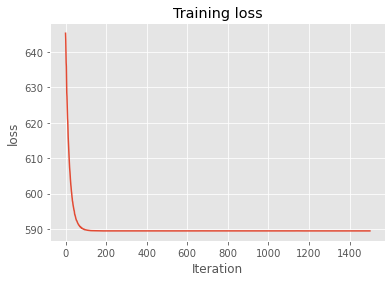

In [20]:
plt.style.use('ggplot')
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Training loss')
plt.plot(loss_history);

In [21]:
print(w.shape)

(3072, 10)


In [34]:
'''w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i, label in enumerate(classes):
    w = w[:,i]
    w = np.reshape(w, (32,32,3))
    w = 225.0 * (w-w_min)/ (w_max-w_min)
    plt.subplot(1, 10, i+1)
    plt.imshow(w)'''

"w_min, w_max = np.min(w), np.max(w)\nclasses = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']\nfor i, label in enumerate(classes):\n    w = w[:,i]\n    w = np.reshape(w, (32,32,3))\n    w = 225.0 * (w-w_min)/ (w_max-w_min)\n    plt.subplot(1, 10, i+1)\n    plt.imshow(w)"

### Prediction

In [49]:
def predict(x,w,b):
    scores, _ = affine_forward(x, w, b)
    return np.argmax(scores, axis=1)

print(x_test.shape)
print(b.shape)

(1000, 3072)
(10,)


In [51]:
'''test_predict = predict( x_test ,w , b)
test_accuracy = 100.0 * np.mean(test_predict==y_test)
print('test accuracy =%.2f'%test_accuracy)'''

"test_predict = predict( x_test ,w , b)\ntest_accuracy = 100.0 * np.mean(test_predict==y_test)\nprint('test accuracy =%.2f'%test_accuracy)"